In [21]:
import gensim
from gensim.corpora import Dictionary
from gensim import corpora, models
import pyLDAvis.gensim
import pandas as pd
import re
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import itertools
%matplotlib inline
import warnings
from string import punctuation

warnings.filterwarnings("ignore")

In [22]:
stop_words  = stopwords.words('english')

In [23]:
user_dict = ['url','username','twitter']
stop_words.extend(user_dict)

In [24]:
def remove_punctuation(string):
    punctuation_zh = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！【】（）、。：；’‘……￥·"""
    punc = punctuation_zh + punctuation
    co = re.compile('[{}]'.format(punc))
    string = co.sub('', string)
    return string

In [25]:
def read_data(file, flag=0):
    docs = []
    doclist = []
    all_words = []
    all_lines = []
    data = pd.read_csv(file)
    for line, label in tqdm(zip(data['text'], data['pred']), total=len(data)):
        if label != flag:
            continue
        line = line.strip()
        if not line:
            continue
        cleaned = []
        temp = []
        seg = line.split(' ')
        for word in seg:
            word = remove_punctuation(word)
            word = word.strip()
            if word in stop_words:
                continue
            if len(word) < 3:
                continue
            if not word:
                continue
            if '丶' in word:
                continue
            if '丨' in word:
                continue
            if '\\' in word:
                continue
            if '─' in word:
                continue
            if '│' in word:
                continue
            contain_num = bool(re.search('[0-9]', word))
            if contain_num:
                continue
            cleaned.append(word)
            all_words.append(word)
        if len(cleaned) != 0:
            temp.append(' '.join(cleaned))
        if len(cleaned) != 0:
            all_lines.append(line)
            doclist.append(cleaned)
        docs.append(' '.join(temp))
    return doclist, all_words

In [26]:
neg_doclist, neg_all_words = read_data('result_pred.csv', 0)
pos_doclist, pos_all_words = read_data('result_pred.csv', 1)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [27]:
def get_counter_cloud(all_words, flag):
    counter = Counter(all_words)
    df = pd.DataFrame(counter.most_common(), columns=['word', 'count'])
    df.to_csv(f"word_counter_{'neg' if flag==0 else 'pos'}.csv",
              index=False,
              encoding='utf-8-sig')
    wordcloud = WordCloud(max_words=200,
                          background_color='white')
    wordcloud.generate_from_frequencies(counter)
    plt.rcParams["figure.dpi"] = 140
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"Word cloud of {'negative' if flag==0 else 'postive'}", fontsize=8)
    plt.savefig(f"word_cloud_{'neg' if flag==0 else 'pos'}.png")
    plt.show()

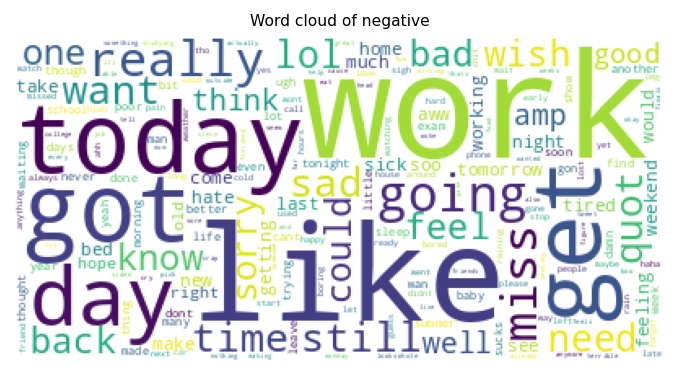

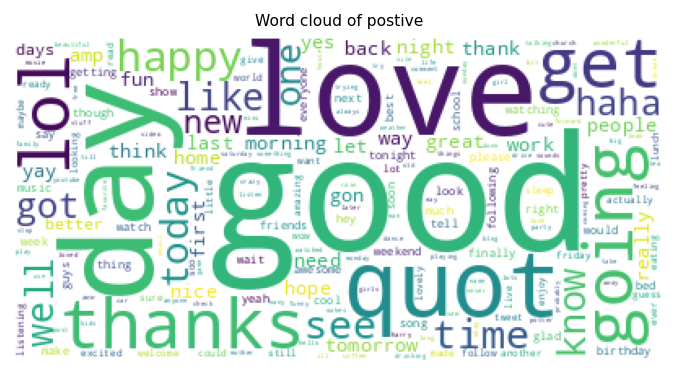

In [28]:
get_counter_cloud(neg_all_words, 0)
get_counter_cloud(pos_all_words, 1)

In [29]:
dict_pos = corpora.Dictionary([[i] for i in pos_all_words])
dict_neg = corpora.Dictionary([[i] for i in neg_all_words])

corpus_pos = [dict_pos.doc2bow(j) for j in [[i] for i in pos_all_words]]
corpus_neg = [dict_neg.doc2bow(j) for j in [[i] for i in neg_all_words]]

In [30]:
def get_topic_words(corpus, dic, i):
    lda = models.ldamulticore.LdaMulticore(corpus,
                                           num_topics=i,
                                           id2word=dic,
                                           random_state=1)
    for j in np.arange(i):
        topic_words = lda.show_topics(num_words=50)
    topics_word = []
    for k in np.arange(i):
        topics_word.append([''.join(re.findall('"(.*)"',i)) \
                       for i in topic_words[k][1].split('+')])
    return topics_word, set(sum(topics_word, []))

In [31]:
def get_sim(topics_word, set_word, i):
    vectors = []
    for j in np.arange(i):
        top_w = topics_word[j]
        vectors.append(tuple([top_w.count(k) for k in set_word]))
    func = list(itertools.permutations(list(np.arange(i)), 2))
    length = len(func)
    sim = [0]
    for w in np.arange(length):
        vector1 = vectors[func[w][0]]
        vector2 = vectors[func[w][1]]
        sim.append(
            cosine_similarity(
                np.array(vector1).reshape(1, -1),
                np.array(vector2).reshape(1, -1))[0][0])
    return sum(sim) / length

In [32]:
def train_lda(corpus, dic):
    sims = [1]
    for i in tqdm(np.arange(2, 11)):
        topics_word, set_word= get_topic_words(corpus, dic, i)
        sim = get_sim(topics_word, set_word, i)
        sims.append(sim)
    return (sims)

In [33]:
pos_k = train_lda(corpus_pos, dict_pos)
neg_k = train_lda(corpus_neg, dict_neg)   

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [34]:
def plot_select_k():
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(211)
    ax1.plot(pos_k)
    ax1.set_xlabel('num topics of positive')
    ax1.set_ylabel('sims')

    ax2 = fig.add_subplot(212)
    ax2.plot(neg_k)
    ax2.set_xlabel('num topics of negative')
    ax2.set_ylabel('sims')
    plt.rcParams["figure.dpi"] = 90
    plt.show()

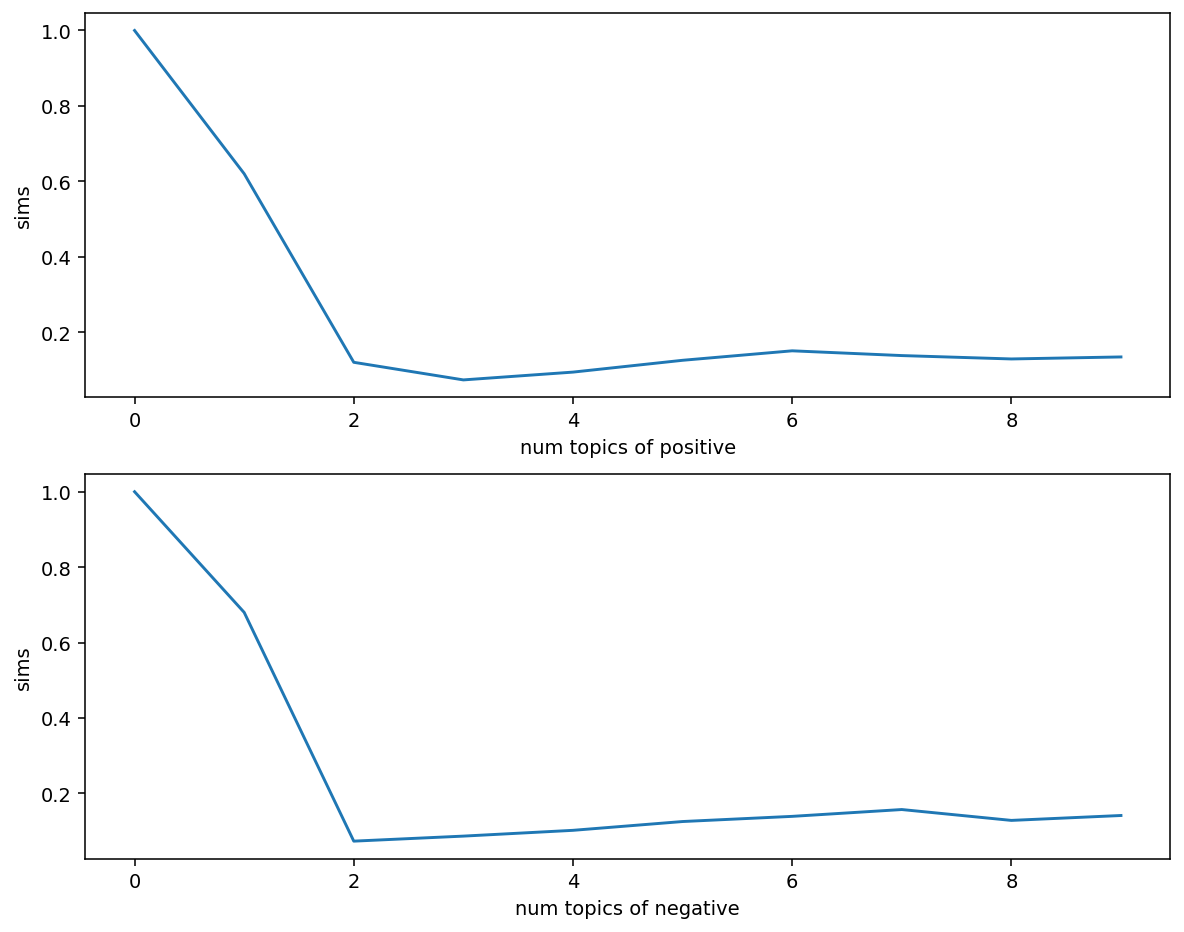

In [35]:
plot_select_k()

In [36]:
def plot_lda(best_num_topics, doclist, flag):
    dictionary = corpora.Dictionary(doclist)
    corpus = [dictionary.doc2bow(doc) for doc in doclist]
    tfidf = models.TfidfModel(corpus)
    corpusTfidf = tfidf[corpus]
    lda_multi = models.ldamulticore.LdaMulticore(corpus=corpusTfidf, id2word=dictionary,num_topics=best_num_topics, \
                iterations=6000, workers=5, batch=True, passes=3, random_state=1) # start training
    print(lda_multi.print_topics())  # output the matrix of topic terms
    lda_display = pyLDAvis.gensim.prepare(lda_multi,
                                          corpus,
                                          dictionary,
                                          sort_topics=True)
    pyLDAvis.save_html(lda_display,
                       f"{'neg' if flag==0 else 'pos' }_topic_visualize.html")
    pyLDAvis.display(lda_display)

In [37]:
plot_lda(2, neg_doclist, 0)
plot_lda(3, pos_doclist, 1)

[(0, '0.004*"work" + 0.004*"miss" + 0.003*"home" + 0.003*"really" + 0.003*"want" + 0.003*"get" + 0.003*"like" + 0.002*"day" + 0.002*"tired" + 0.002*"sad"'), (1, '0.003*"got" + 0.003*"today" + 0.003*"feel" + 0.003*"day" + 0.003*"like" + 0.003*"work" + 0.003*"wish" + 0.003*"good" + 0.002*"know" + 0.002*"still"')]
[(0, '0.005*"love" + 0.005*"thanks" + 0.004*"great" + 0.004*"night" + 0.003*"lol" + 0.003*"welcome" + 0.003*"good" + 0.003*"yeah" + 0.003*"got" + 0.003*"day"'), (1, '0.004*"nice" + 0.004*"time" + 0.003*"thank" + 0.003*"fun" + 0.003*"gon" + 0.002*"haha" + 0.002*"thanks" + 0.002*"look" + 0.002*"watching" + 0.002*"day"'), (2, '0.007*"good" + 0.005*"happy" + 0.004*"day" + 0.004*"quot" + 0.004*"morning" + 0.003*"one" + 0.003*"know" + 0.003*"going" + 0.003*"lol" + 0.003*"well"')]
